# **Benetech - Making Graphs Accessible**
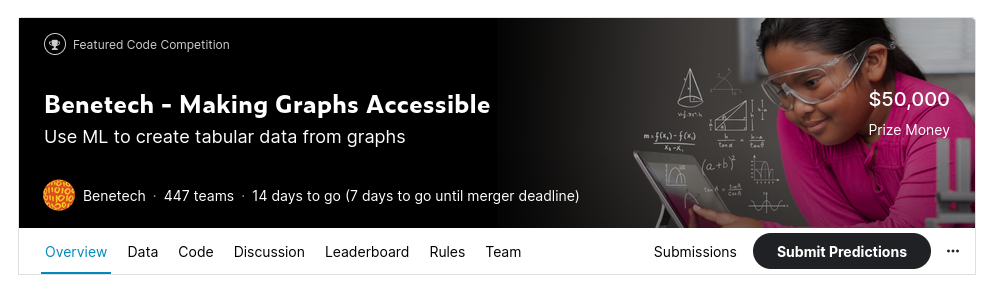
> <pre>@misc{benetech-making-graphs-accessible,
    author = {Benji Andrews, benjiaa, HCL-Rantig, Hema Natarajan, Maggie, Ryan Holbrook},
    title = {Benetech - Making Graphs Accessible},
    publisher = {Kaggle},
    year = {2023},
    url = {https://kaggle.com/competitions/benetech-making-graphs-accessible}
} </pre>

In [1]:
!pip install git+https://github.com/huggingface/transformers --quiet
!pip install -U watermark accelerate==0.20.3 --quiet
!pip install -U datasets pyarrow polyleven keras-ocr -q
%load_ext watermark
%watermark -a 'NavinKumarMNK' -v -p torch,transformers,wandb

Author: NavinKumarMNK

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.13.2

torch       : 2.0.0+cpu
transformers: 4.31.0.dev0
wandb       : 0.15.4



## **Modules Import**

In [2]:
import polars as pol
import pandas as pd
import numpy as np
import wandb

import torch
import pytorch_lightning as pl
from transformers import Pix2StructForConditionalGeneration, Pix2StructProcessor, AutoProcessor, Pix2StructConfig, get_linear_schedule_with_warmup 

import requests
from PIL import Image
import os
import re
import json
from collections import Counter
from itertools import chain
from pathlib import Path
from typing import List, Dict, Union, Tuple, Any
import pprint
pprint = pprint.pprint

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from datasets import Dataset
from datasets import Image as ds_img
from polyleven import levenshtein

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import warnings
warnings.simplefilter("ignore")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## **Configuration**

In [3]:
class Config:
    # General
    debug = False
    num_proc = 2
    num_workers = 2
    gpus = 2

    # Data
    data_dir = Path('/kaggle/input/benetech-making-graphs-accessible/train')
    images_path = data_dir/'images'
    train_json_files = list(data_dir.glob('annotations/*.json'))

    # Training
    epochs = 5
    val_check_interval = 1.0
    check_val_every_n_epoch = 1
    gradient_clip_val = 2.0
    lr = 2e-5
    lr_scheduler_type = "cosine"
    num_warmup_steps = 100
    seed = 42
    output_path = "output"
    log_steps = 200
    batch_size = 2
    use_wandb = True
    
    image_height = 512
    image_width  = 512
    max_length = 512
    max_patches = 1024


## **Preprocessing Annotations**

In [4]:
PROMPT_TOKEN = "<|BOS|>"
X_START = "<x_start>"
X_END = "<x_end>"
Y_START = "<y_start>"
Y_END = "<y_end>"

SEPARATOR_TOKENS = [
    PROMPT_TOKEN,
    X_START,
    X_END,
    Y_START,
    Y_END,
]

LINE_TOKEN =  "<line>" 
VERTICAL_BAR_TOKEN = "<vertical_bar>"
HORIZONTAL_BAR_TOKEN = "<horizontal_bar>"
SCATTER_TOKEN = "<scatter>"
DOT_TOKEN = "<dot>"

CHART_TYPE_TOKENS = [
    LINE_TOKEN,
    VERTICAL_BAR_TOKEN,
    HORIZONTAL_BAR_TOKEN,
    SCATTER_TOKEN,
    DOT_TOKEN,
]

NEW_TOKENS = SEPARATOR_TOKENS + CHART_TYPE_TOKENS

In [5]:
class Preprocessor:
    def round_float(self, value: Union[int, float, str]) -> Union[str, float]:
        """
        @brief  : Convert float value into string => >1 digit in int => trunc. 1 decimal ,else trunc. 4 decimals
        @args   : value [int, float, str] : float value to convert
        @return : str : flat value as string
        """
        if isinstance(value, float):
            value = str(value)

            if '.' in value: 
                integer, decimal = value.split(".")
                if abs(float(integer)) > 1 :
                    decimal = decimal[:1]
                else:
                    decimal = decimal[:4]

                value = integer + "." + decimal

        return value
    
    def is_nan(self, value: Union[int, float, str]) -> bool:
        """
        @brief  : Check if value is NaN
        @args   : value [int, float, str] : value to check
        @return : bool : True if value is NaN, else False
        """
        if isinstance(value, str):
            return value.lower() == 'nan'
        return value != value
    
    
    def get_gt_string_and_xy(self, filepath: Union[str, os.PathLike]) -> Dict[str, str]:
        """
        @brief  : Get ground truth string and xy coordinates from filepath
        @args   : filepath [str, os.PathLike] : filepath to get gt string and xy coordinates
        @return : Dict[str, str] : gt string and xy coordinates
        """
        filepath = Path(filepath)
        with open(filepath) as fp:
            data = json.load(fp)
            
        data_series = data["data-series"]
        all_x, all_y = [], []

        for d in data_series:
            x, y = d["x"], d["y"]
            x, y = self.round_float(x), self.round_float(y)

            if self.is_nan(x) or self.is_nan(y):
                continue

            all_x.append(x)
            all_y.append(y)

        chart_type = f"<{data['chart-type']}>"
        x_str = X_START + ";".join(list(map(str, all_x))) + X_END
        y_str = Y_START + ";".join(list(map(str, all_y))) + Y_END

        gt_string = PROMPT_TOKEN + chart_type + x_str + y_str

        return {
            "ground_truth": gt_string,
            "x": json.dumps(all_x),
            "y": json.dumps(all_y),
            "chart-type": data["chart-type"],
            "id": filepath.stem,
            "source": data["source"],
        }
        

In [6]:
pprint(Preprocessor().get_gt_string_and_xy(Config.data_dir / "annotations" / "0000ae6cbdb1.json"))

{'chart-type': 'vertical_bar',
 'ground_truth': '<|BOS|><vertical_bar><x_start>Malawi;Malaysia;Maldives;Mali;Malta;Martinique;Mauritania;Mauritius;Mayotte;Melanesia<x_end><y_start>837799.9;960480.6;750170.9;697593.4;574912.8;452232.1;653778.9;539861.2;417180.5;574912.8<y_end>',
 'id': '0000ae6cbdb1',
 'source': 'generated',
 'x': '["Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Martinique", '
      '"Mauritania", "Mauritius", "Mayotte", "Melanesia"]',
 'y': '["837799.9", "960480.6", "750170.9", "697593.4", "574912.8", '
      '"452232.1", "653778.9", "539861.2", "417180.5", "574912.8"]'}


## **Dataset**

### **Non-Competition Dataset**

In [7]:

df = pol.read_csv("/kaggle/input/benetech-extra-generated-data/metadata.csv")
graph_types = {
    "d":"dot",
    "h":"horizontal_bar",
    "s":"scatter",
    "l":"line",
    "v":"vertical_bar"
}


In [8]:
def convert_extra_to_df(df):
    main_dct = {}
    try:
        for row in df.rows():
            dct = {}
            graph, image_id = row[0].split('/')
            graph_type = graph_types[graph.split("_")[1]]
            image_id = graph_type + "-" + image_id

            data_series = row[1].split(' <0x0A> ')
            _x = []
            _y = []
            for data in data_series:
                x, y = data.split(' | ')
                _x.append(x)
                _y.append(y)

            x_str = X_START + ";".join(list(map(str, _x))) + X_END
            y_str = Y_START + ";".join(list(map(str, _y))) + Y_END

            gt_string = PROMPT_TOKEN + '<'+graph_type+'>' + x_str + y_str

            dct['chart-type'] = graph_type
            dct['ground_truth'] = gt_string
            dct['id'] = image_id
            dct['source'] = 'extra'
            dct['x'] = _x
            dct['y'] = _y
            main_dct[image_id] = dct
    except Exception as e:
        print(e, row)
            
    df_new = pd.DataFrame.from_dict(main_dct, orient='index')
    return df_new       


In [12]:
df_old = convert_extra_to_df(df)
df_old.head()

'val' ('graphs_val/000b92c3b098.jpg', '0 | 0.01 <0x0A> 6 | -0.68 <0x0A> 12 | -1.38 <0x0A> 18 | -2.08 <0x0A> 24 | -2.74', 1, 5, 'line')


,chart-type,ground_truth,id,source,x,y
dot-0.jpg,dot,<|BOS|><dot><x_start>15 to 20;16 to 23;15 to 1...,dot-0.jpg,extra,"[15 to 20, 16 to 23, 15 to 18, 19 to 20, 19 to...","[2, 6, 4, 2, 7, 8, 5, 9, 6, 9, 3]"
dot-1.jpg,dot,<|BOS|><dot><x_start>44 to 49;42 to 49;41 to 4...,dot-1.jpg,extra,"[44 to 49, 42 to 49, 41 to 49, 37 to 44, 43 to...","[7, 8, 1, 8, 8, 6, 4, 8, 9, 5, 3, 9]"
dot-2.jpg,dot,<|BOS|><dot><x_start>11 to 19kg;8 to 16kg;13 t...,dot-2.jpg,extra,"[11 to 19kg, 8 to 16kg, 13 to 21kg, 10 to 14kg...","[6, 6, 8, 9, 3, 3, 7, 3, 3, 4, 4, 3, 8, 1, 2, ..."
dot-3.jpg,dot,<|BOS|><dot><x_start>18 to 25yr;5 to 9yr;27 to...,dot-3.jpg,extra,"[18 to 25yr, 5 to 9yr, 27 to 34yr, 59 to 65yr,...","[6, 8, 6, 6, 3, 9, 1, 6, 5, 2, 5, 8, 2, 5, 1, ..."
dot-4.jpg,dot,<|BOS|><dot><x_start>January;Febuary;March;Apr...,dot-4.jpg,extra,"[January, Febuary, March, April, May, June, Ju...","[3, 1, 8, 4, 3, 1, 6, 9, 1, 2, 8]"


### **Competition Dataset**

In [10]:
dct = {}
pre = Preprocessor()
for no, i in enumerate(Config.train_json_files):
    j = pre.get_gt_string_and_xy(i)
    dct[j['id']+'.jpg'] = j

df_new = pd.DataFrame.from_dict(dct, orient='index')
df_new.head()


,ground_truth,x,y,chart-type,id,source
cc68f19b708c.jpg,<|BOS|><line><x_start>10%;20%;30%;40%;50%;60%;...,"[""10%"", ""20%"", ""30%"", ""40%"", ""50%"", ""60%"", ""70%""]","[""1.5481"", ""11.5"", ""14.0"", ""12.2"", ""7.9"", ""1.7...",line,cc68f19b708c,extracted
0e6a9bca7381.jpg,<|BOS|><line><x_start>2003;2004;2005;2006;2007...,"[""2003"", ""2004"", ""2005"", ""2006"", ""2007"", ""2008...","[""90.0"", ""88.1"", ""65.1"", ""67.8"", ""70.2"", ""82.2...",line,0e6a9bca7381,generated
ac9680f519f5.jpg,<|BOS|><scatter><x_start>1990.1;1991.0;1991.9;...,"[""1990.1"", ""1991.0"", ""1991.9"", ""1992.9"", ""1993...","[""244.2"", ""201.9"", ""186.1"", ""214.1"", ""194.7"", ...",scatter,ac9680f519f5,generated
4a6cce801fe8.jpg,<|BOS|><scatter><x_start>1989.8;1991.9;1993.9;...,"[""1989.8"", ""1991.9"", ""1993.9"", ""1995.9"", ""1997...","[""1996.1"", ""2085.8"", ""2265.2"", ""2457.3"", ""2636...",scatter,4a6cce801fe8,generated
19938a5762f6.jpg,<|BOS|><line><x_start>Jan;Feb;Mar;Apr;May;Jun;...,"[""Jan"", ""Feb"", ""Mar"", ""Apr"", ""May"", ""Jun"", ""Ju...","[""26.4"", ""25.4"", ""25.9"", ""26.3"", ""26.8"", ""26.9...",line,19938a5762f6,generated


In [27]:
df_old = df_old.reindex(columns=df_new.columns)
train_df = pd.concat([df_old, df_new], axis=0)
train_df.reset_index(inplace=True)
train_df.rename(columns={'index': 'path'}, inplace=True)
train_df

,path,ground_truth,x,y,chart-type,id,source
0,dot-0.jpg,<|BOS|><dot><x_start>15 to 20;16 to 23;15 to 1...,"[15 to 20, 16 to 23, 15 to 18, 19 to 20, 19 to...","[2, 6, 4, 2, 7, 8, 5, 9, 6, 9, 3]",dot,dot-0.jpg,extra
1,dot-1.jpg,<|BOS|><dot><x_start>44 to 49;42 to 49;41 to 4...,"[44 to 49, 42 to 49, 41 to 49, 37 to 44, 43 to...","[7, 8, 1, 8, 8, 6, 4, 8, 9, 5, 3, 9]",dot,dot-1.jpg,extra
2,dot-2.jpg,<|BOS|><dot><x_start>11 to 19kg;8 to 16kg;13 t...,"[11 to 19kg, 8 to 16kg, 13 to 21kg, 10 to 14kg...","[6, 6, 8, 9, 3, 3, 7, 3, 3, 4, 4, 3, 8, 1, 2, ...",dot,dot-2.jpg,extra
3,dot-3.jpg,<|BOS|><dot><x_start>18 to 25yr;5 to 9yr;27 to...,"[18 to 25yr, 5 to 9yr, 27 to 34yr, 59 to 65yr,...","[6, 8, 6, 6, 3, 9, 1, 6, 5, 2, 5, 8, 2, 5, 1, ...",dot,dot-3.jpg,extra
4,dot-4.jpg,<|BOS|><dot><x_start>January;Febuary;March;Apr...,"[January, Febuary, March, April, May, June, Ju...","[3, 1, 8, 4, 3, 1, 6, 9, 1, 2, 8]",dot,dot-4.jpg,extra
...,...,...,...,...,...,...,...
560573,d3953f6dc2b6.jpg,<|BOS|><vertical_bar><x_start>Bar Charts;Pie G...,"[""Bar Charts"", ""Pie Graphs"", ""Histograms"", ""Pi...","[5, 2, 3, 8, 4, 9, 1, 5]",vertical_bar,d3953f6dc2b6,extracted
560574,292f04b08480.jpg,<|BOS|><vertical_bar><x_start>Czechia;Democrat...,"[""Czechia"", ""Democratic..."", ""Denmark"", ""Djibo...","[""12496709.2"", ""62846351.7"", ""12496709.2"", ""97...",vertical_bar,292f04b08480,generated
560575,2af23469c1d8.jpg,<|BOS|><vertical_bar><x_start>Agriculture;Fish...,"[""Agriculture"", ""Fishing"", ""Mining"", ""Food"", ""...","[""0.0855"", ""0.0279"", ""0.2454"", ""0.0727"", ""0.47...",vertical_bar,2af23469c1d8,extracted
560576,fc88838dcd7d.jpg,<|BOS|><line><x_start>Channel Islands;Chile;Ch...,"[""Channel Islands"", ""Chile"", ""China"", ""Colombi...","[""98.5"", ""101.5"", ""105.3"", ""100.8"", ""103.5"", ""...",line,fc88838dcd7d,generated


In [28]:
train_df = train_df[['chart-type', 'ground_truth', 'source', 'path']]
data = train_df.to_dict(orient='records')

with open('train_data.json', 'w') as f:
    json.dump(data, f)

In [29]:
val_df = train_df[train_df['source']=='extracted']
val_df.rename(columns={'Unnamed: 0': 'path'}, inplace=True)
val_df = val_df[['chart-type', 'ground_truth', 'source', 'path']]
val_df = val_df.rename_axis(None)

data = val_df.to_dict(orient='records')

with open('val_data.json', 'w') as f:
    json.dump(data, f)


## **Model**

In [52]:
config = Pix2StructConfig.from_pretrained("google/matcha-base")
config.max_length = Config.max_length

In [53]:
model = Pix2StructForConditionalGeneration.from_pretrained("google/matcha-base")
processor = AutoProcessor.from_pretrained("google/matcha-base", is_vqa=False)

In [54]:
image_path = "/kaggle/input/benetech-extra-generated-data/graphs_d/0.jpg"
image = Image.open(image_path)

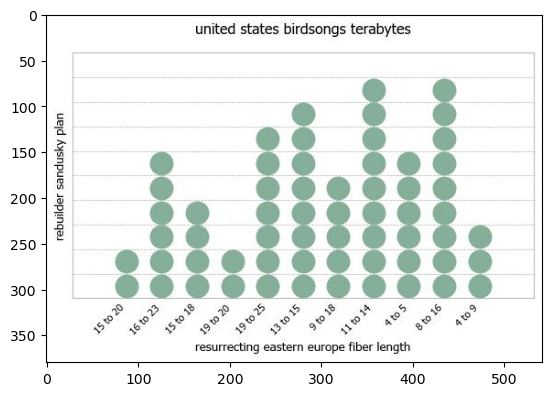

In [55]:
plt.imshow(image)

In [34]:
model.config.text_config.is_decoder=True
with torch.no_grad():
    inputs = processor(images=image, text="",
                      return_tensors="pt")
    predictions = model.generate(**inputs, max_new_tokens=64)
    print(processor.decode(
        predictions[0], skip_special_tokens=True
    ))

Dataset(csv_path + "res_birdsongs.csv", "United States.csv", "united_states.csv", "united_states_terabytes.csv")


In [35]:
with open("/kaggle/working/train_data.json", "r") as fl:
    train_dataset = json.load(fl)
    
with open("/kaggle/working/val_data.json", "r") as fl:
    val_dataset = json.load(fl)


In [36]:
def check_for_unk(examples: Dict[str, str]) -> Dict[str, List[str]]:
    texts = list(examples['ground_truth'].values())
    ids = processor.tokenizer(texts).input_ids
    tokens = [processor.tokenizer.tokenize(x, add_special_tokens=True) for x in texts]
    
    unk_tokens = []
    for example_ids, example_tokens in zip(ids, tokens):
        example_unk_tokens = []
        for i in range(len(example_ids)):
            if example_ids[i] == processor.tokenizer.unk_token_id:
                example_unk_tokens.append(example_tokens[i])

        unk_tokens.append(example_unk_tokens)

    return {"unk_tokens": unk_tokens}

In [37]:
'''
unk = pd.DataFrame(check_for_unk(train_df.to_dict()))
unk = unk.loc[unk["unk_tokens"].apply(len) > 0]
unk
'''

,unk_tokens
501001,"[\n\n, \n\n, \n\n, \n\n, \n\n, \n\n, \n\n, \n\..."
501735,"[\n, \n]"
504582,"[\n, \n, \n, \n, \n, \n, \n, \n]"
505035,[\n\n]
505059,"[\n, \n, \n]"
...,...
556376,[\n]
557179,[\n]
557556,[\n]
559269,[\n]


In [38]:
example_str = "\n"
temp_ids = processor.tokenizer(example_str).input_ids
print("ids:", temp_ids)
print("tokenized:", processor.tokenizer.tokenize(example_str))
print("decoded:", processor.tokenizer.decode(temp_ids))
num_added = processor.tokenizer.add_tokens(["\n"] + NEW_TOKENS)
print(num_added, "tokens added")

config.pad_token_id = processor.tokenizer.pad_token_id
config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids([PROMPT_TOKEN])[0]


ids: [273, 3, 1]
tokenized: ['▁', '\n']
decoded: <unk></s>
11 tokens added


## **Training**

In [57]:
graph_types_rev = {
    "dot":"d",
    "horizontal_bar":"h",
    "scatter":"s",
    "line":"l",
    "vertical_bar":"v"
}

def augments():
        return A.Compose([
            A.Resize(width=Config.image_height, height=Config.image_width),
            A.Normalize(
                mean=[0, 0, 0], 
                std=[1, 1, 1],
                max_pixel_value=255,
            ),
            ToTensorV2(),
        ])


class BeneTechDataset(TorchDataset):
    def __init__(self, dataset, processor, ):
        self.dataset = dataset
        self.processor = processor
        self.augmenter = augments()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx] 
        if item['source'] == 'extra':
            path = "/kaggle/input/benetech-extra-generated-data/"
            path = path + "graphs_" + graph_types_rev[item['chart-type']] + "/"
            path = path + item['path'].split('-')[-1]
        else:
            path = "/kaggle/input/benetech-making-graphs-accessible/train/images/"
            path = path + item['path']

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = self.augmenter(image=image)['image']
        encoding = self.processor(
            images=torch.Tensor(image),
            return_tensors="pt", 
            add_special_tokens=True, 
            max_patches=Config.max_patches
        )

        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = item['ground_truth']
        
        return encoding


class BeneTechDataModule(pl.LightningDataModule):
    def __init__(self, dataset, val_dataset, processor, batch_size=1, num_workers=1):
        super().__init__()
        self.dataset = dataset
        self.val_dataset = val_dataset
        self.processor = processor
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.train_dataset = BeneTechDataset(self.dataset, self.processor)
        self.val_dataset = BeneTechDataset(self.dataset, self.processor)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
            shuffle=True,
            collate_fn=self.collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self.collate_fn
        )

    def collate_fn(self, batch):
        new_batch = {"flattened_patches": [], "attention_mask": []}
        texts = [item["text"] for item in batch]
        encoding = self.processor(
            text=texts,
            return_tensors="pt", 
            padding=True, 
            truncation=True, 
            add_special_tokens=True,
            max_length=Config.max_length
        )
        new_batch["labels"] = encoding.input_ids
        for item in batch:
            new_batch["flattened_patches"].append(item["flattened_patches"])
            new_batch["attention_mask"].append(item["attention_mask"])
        new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
        new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])
        return new_batch



In [58]:
class MatChaFineTuned(pl.LightningModule):
    def __init__(self, processor,
                    model,
                    input_dim:int=512,
                    model_path:str=None,):
        super(MatChaFineTuned, self).__init__()
        
        self.processor = processor
        self.model = model
        self.input_dim = input_dim
        self.model_path = model_path

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx:int) -> torch.Tensor:
        labels = batch['labels']
        flattened_patches = batch['flattened_patches']
        attention_mask = batch['attention_mask']
        print(len(flattened_patches[0]), len(attention_mask[0]), len(labels[0]))
        outputs = self.model(flattened_patches, attention_mask, labels=labels)
        loss = outputs.loss
        self.log('train_loss', loss)
        return loss

    def validataion_step(self, batch: Dict[str, torch.Tensor], batch_idx:int,
                         dataset_indx: int=0) -> None:
        labels = batch['labels']
        flattened_patches = batch['flattened_patches']
        attention_mask = batch['attention_mask']
        outputs = self.model(flattened_patches, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-5, weight_decay=0.001)
        return optimizer      

    def save_model(self):
        torch.save(self.model, self.model_path+'.pt')

In [59]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import callbacks as pl_callbacks

wandb_logger = WandbLogger(project="matcha", name="matcha")
wandb_logger.watch(model, log='all', log_freq=100)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [61]:
model_train = MatChaFineTuned(
    processor=processor,
    model=model,

    input_dim=512,
    model_path="models/matcha",
)

dataset = BeneTechDataModule(train_dataset, val_dataset, processor, batch_size=2, num_workers=2)
dataset.setup()

callbacks = [
    pl_callbacks.ModelCheckpoint(
        monitor='val_loss',
        dirpath='/workspace/Benetech-Kaggle-Competition/models/checkpoints',
        filename='matcha-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,
        mode='min',
    ),
    pl_callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
    ),
    pl_callbacks.LearningRateMonitor(logging_interval='epoch'),
    pl_callbacks.TQDMProgressBar(),
]

In [ ]:
trainer = pl.Trainer(
    max_epochs=10,
    precision=16,
    callbacks=callbacks,
    logger=wandb_logger,
    profiler='simple',
    log_every_n_steps=1,
    accumulate_grad_batches=8,
)

trainer.fit(model_train, dataset)
model.save_model()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
1024 1024 512
